In [ ]:
# Mount Google Drive to save and access files
from google.colab import drive
drive.mount('/content/drive')

# Install FastAI (if not already installed)
!pip install fastai


Mounted at /content/drive


In [ ]:
from pathlib import Path

# Path to your dataset
data_path = Path("/content/drive/MyDrive/Nonsegmented")

# Check folder structure and display folder names
folders = [f for f in data_path.iterdir() if f.is_dir()]
print("Folders in dataset:", [folder.name for folder in folders])


Folders in dataset: ['Shepherd’s Purse', 'Common wheat', 'Fat Hen', 'Maize', 'Common Chickweed', 'Cleavers', 'Sugar beet', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Loose Silky-bent', 'Black-grass', 'Charlock']


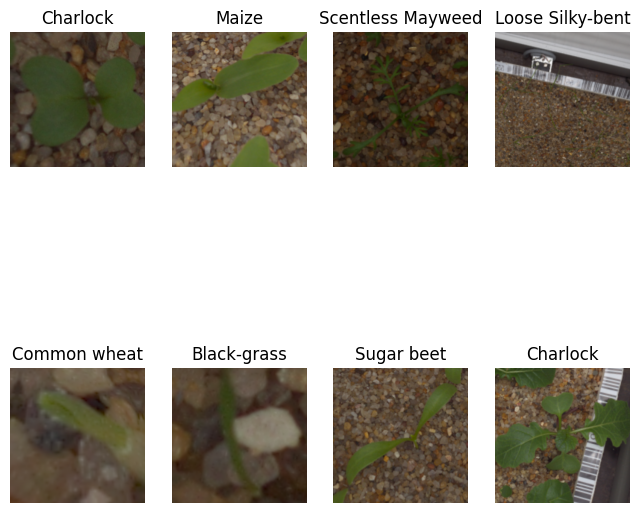

In [ ]:
from fastai.vision.all import *

# Create DataLoaders for the dataset
dls = ImageDataLoaders.from_folder(
    data_path,
    valid_pct=0.2,        # Use 20% of the data for validation
    seed=42,              # Seed for reproducibility
    item_tfms=Resize(224), # Resize images to 224x224 (ResNet requirement)
    batch_tfms=aug_transforms(do_flip=True, max_rotate=30, max_zoom=1.1) # Augmentations
)

# Show a batch of images
dls.show_batch(max_n=8, figsize=(8, 8))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.3MB/s]


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0014454397605732083)

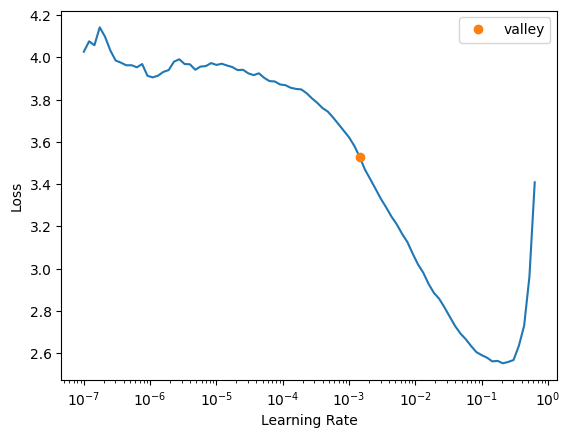

In [ ]:
# Create a learner with ResNet50
learn_plant = vision_learner(
    dls,
    resnet50,             # Use ResNet50 as the backbone
    metrics=accuracy      # Track accuracy during training
)

# Find the optimal learning rate
learn_plant.lr_find()


In [ ]:
# Save the partially trained model
learn_plant.export("/content/drive/MyDrive/PlantTypeDetector.pkl")


In [ ]:
# Fine-tune the model
learn_plant.fine_tune(5, base_lr=0.001)


epoch,train_loss,valid_loss,accuracy,time
0,2.145392,0.849470,0.726781,07:47


epoch,train_loss,valid_loss,accuracy,time
0,1.071802,0.474022,0.840397,01:31
1,0.731097,0.363347,0.866546,01:30
2,0.527963,0.286733,0.891794,01:31
3,0.391679,0.240063,0.908927,01:29
4,0.347866,0.234843,0.908927,01:30


In [ ]:
# Save the partially trained model
learn_plant.export("/content/drive/MyDrive/PlantTypeDetector.pkl")


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

from fastai.vision.all import *
learn_plant = load_learner("PlantTypeDetector.pkl")


In [3]:
unseen_img_path = "11.png"  # Replace with your image path
unseen_img = PILImage.create(unseen_img_path)
predicted_class, _, probs = learn_plant.predict(unseen_img)
print(f"Predicted Class: {predicted_class}")


Predicted Class: Sugar beet


In [5]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np

# Load the pre-trained model
learn = load_learner("PlantTypeDetector.pkl")

# Define the path to your images and ensure correct file extension
image_folder = Path('testdata_withoutlevel')
images = list(image_folder.glob('*.png'))  # Assuming all your images are PNG format

# Function to classify images and return actual class
def classify_image(image_path):
    img = PILImage.create(image_path)
    pred_class, _, _ = learn.predict(img)
    return str(pred_class)

# Drone task to examine each image and log the type
def log_image_types(images):
    types_and_names = []
    with open('image_types.txt', 'w') as file:
        for img in images:
            image_type = classify_image(img)
            image_name = img.stem  # Extracts the file name without extension
            file.write(f"{image_name}_{image_type}\n")
            types_and_names.append((image_name, image_type))
    return types_and_names

# Process the images and log their types
types_and_names = log_image_types(images)

# Define plant classes
plant_classes = {'Maize', 'Sugar beet', 'Common wheat'}

# Classify images as 'plant' or 'weed' and reshape into a 30x30 grid for simulation
results = np.array(['plant' if typ[1] in plant_classes else 'weed' for typ in types_and_names]).reshape(30, 30)

# Prepare the image map from image paths
image_map = {divmod(i, 30): img for i, img in enumerate(images)}

# Drone simulation for plant and weed management
def simulate_drones(classified_grid, image_map):
    total_removed = 0
    total_length = 0
    log_entries = []
    filename_log_entries = []
    plant_entries = []

    # Set the starting position of the weed removal drone at (0, 0)
    drone_position = (0, 0)  # Top-left corner as the starting position

    def path_length(start, end):
        return abs(end[0] - start[0]) + abs(end[1] - start[1])

    for i in range(30):
        for j in range(30):
            image_index = i * 30 + j
            image_name = image_map[(i, j)].stem
            category = classified_grid[i][j]
            formatted_index = f"{image_index:03d}"

            if category == 'weed':
                length = path_length(drone_position, (i, j))
                total_length += length

                from_index = f"{drone_position[0] * 30 + drone_position[1]:03d}"
                to_index = formatted_index
                log_entry = f"Image{formatted_index}, ({drone_position}) to ({i}, {j}), {length}"
                filename_log_entry = f"Image{image_name}, {from_index} to {to_index}, {length}"

                log_entries.append(log_entry)
                filename_log_entries.append(filename_log_entry)

                # Update the position of the drone
                drone_position = (i, j)
                total_removed += 1
            elif category == 'plant':
                plant_entries.append(image_name)

    # Write results to files
    with open('removedPlantsWithCoordinates.txt', 'w') as file:
        for entry in log_entries:
            file.write(entry + "\n")
        file.write(f"Overall: {total_removed}, {total_length}\n")

    with open('removedPlants.txt', 'w') as file:
        for entry in filename_log_entries:
            file.write(entry + "\n")
        file.write(f"Overall: {total_removed}, {total_length}\n")

    with open('watering_plants.txt', 'w') as file:
        for plant in plant_entries:
            file.write(plant + "\n")

# Execute the simulation with the mapped images and results
simulate_drones(results, image_map)


In [11]:
import os
import csv

# Input and output directories
image_dir = "testdata_withoutlevel"  # Replace with your directory containing images
output_csv = "grid_30x30.csv"

# Set grid size
grid_size = 30  # 30x30 grid
total_images = grid_size * grid_size

# Collect all images in the directory
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))])

# Check if there are exactly 900 images
if len(image_files) < total_images:
    print(f"Error: Found {len(image_files)} images. Need 900 images for a 30x30 grid.")
    exit()
elif len(image_files) > total_images:
    print(f"Warning: Found more than 900 images. Only the first 900 will be used.")

# Prepare grid data
grid_data = []
for row in range(grid_size):
    grid_row = []
    for col in range(grid_size):
        index = row * grid_size + col
        grid_row.append(image_files[index])
    grid_data.append(grid_row)

# Save grid data to a CSV file
with open(output_csv, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(grid_data)

# Confirm success
print(f"Grid CSV file '{output_csv}' has been created successfully.")
print(f"The file contains a 30x30 grid of images.")


Grid CSV file 'grid_30x30.csv' has been created successfully.
The file contains a 30x30 grid of images.
